# Lab: Ring Resonator Transmission
MIT 6.S976: Silicon Photonics HW9. Written by Shoumik Chowdhury (@shoumikdc)

In [2]:
""" Import Relevant Packages """
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

""" Useful Constants"""
π = np.pi; nm = 1; μm = 1000; # base unit is nm here

In [257]:
""" Data Loading and Analysis Functions """
def data_from_file(filename):
    # Extract transmission spectrum vs. frequency data from file.
    file = np.loadtxt(filename, delimiter=",", dtype=float)
    freqs = file[:, 0]; transmission = file[:, 1]
    
    return freqs, transmission


def calc_FWHM(x, y_dB, FWHM_dB = -3):
    """
    Method to calculate the full-width at half-maximum Δϕ from a sweep. 
    We use -3dB as the threshold for "half maximum"
    """
    # Get indices of the two smallest values of the array
    idx1, idx2 = np.argpartition(np.abs(y_dB - FWHM_dB), 2)[:2]

    Δx = x[idx1] - x[idx2]
    
    return np.abs(Δx), [idx1, idx2] # return absolute value to ensure positivity

In [377]:
def run_analysis(gap, plotting = True):
    
    results = {}
    
    
    """ 1. Get Data for Coarse Sweep """
    data_coarse = f"Data/0_NoDrop/gap{gap}"
    freqs, transmission = data_from_file(data_coarse)
    
    """ 2. Find Peaks in the Coarse Dataset """
    peak_idxs, _ = find_peaks(-transmission, prominence=1)
    peak_freq, peak_T = freqs[peak_idxs], transmission[peak_idxs]
    
    if plotting:
        fig, ax = plt.subplots(1, 2, figsize = (10, 3), dpi = 200)
        ax[0].plot(freqs, transmission, label = "Data")
        ax[0].plot(peak_freq, peak_T, "x", label = "Resonances")
        ax[0].legend(fontsize = 8)
        ax[0].set_title(f"Coarse Sweep: Gap = {gap} nm", fontsize = 11)
        ax[0].set_ylabel("Transmission (dB)")
        ax[0].set_xlabel(r"Wavelength $\lambda$ (nm)")

    
    # Calculate resonances and average separation (FSR)
    results["resonances"] = [peak_freq, peak_T]
    results["avg_FSR"] = (peak_freq[-1] - peak_freq[0]) / (len(peaks) - 1)
    
    
    """ 3. Fine Sweep """
    data_fine = f"Data/0_NoDrop/gap{gap}_really_fine"
    freqs, transmission = data_from_file(data_fine)
    results["baseline_fine"] = np.max(transmission)

    FWHM_level = -10*np.log10(0.5) # approx 3 dB
    results["extinction"] = results["baseline_fine"] - np.min(transmission)
    results["FWHM"], idxs = calc_FWHM(freqs, transmission, results["baseline_fine"] - FWHM_level)
    results["λ_near_1550"] = freqs[np.argmin(transmission)]
    
    results["Q"] = results["λ_near_1550"] / results["FWHM"] # Q = λ/Δλ
    
    if plotting:
        ax[1].plot(freqs, transmission, label = "Data")
        ax[1].legend(fontsize = 8)
        ax[1].set_title(f"Fine Sweep: Gap = {gap} nm", fontsize = 11)
        ax[1].set_xlabel(r"Wavelength $\lambda$ (nm)")
        ax[1].axvline(freqs[idxs[0]], c='k', zorder=-2)
        ax[1].axvline(freqs[idxs[1]], c='k', zorder=-2)
        ax[1].axhline(results["baseline_fine"] - FWHM_level, c='k', linestyle='--', zorder=-2)
        plt.locator_params(axis='x', nbins=7)

    
    return results    

## 0. Through Port Measurements
Here we measure a set of ring resonators each respectively coupled to a single through port. We measure the through port transmission spectrum in each case. 

{'resonances': [array([1524., 1557., 1592.]),
  array([-13.92809, -16.68416, -17.7867 ])],
 'avg_FSR': 34.0,
 'baseline_fine': -10.57662,
 'extinction': 7.0818400000000015,
 'FWHM': 1.9299999999982447,
 'λ_near_1550': 1556.7799999999975,
 'Q': 806.6217616587634}

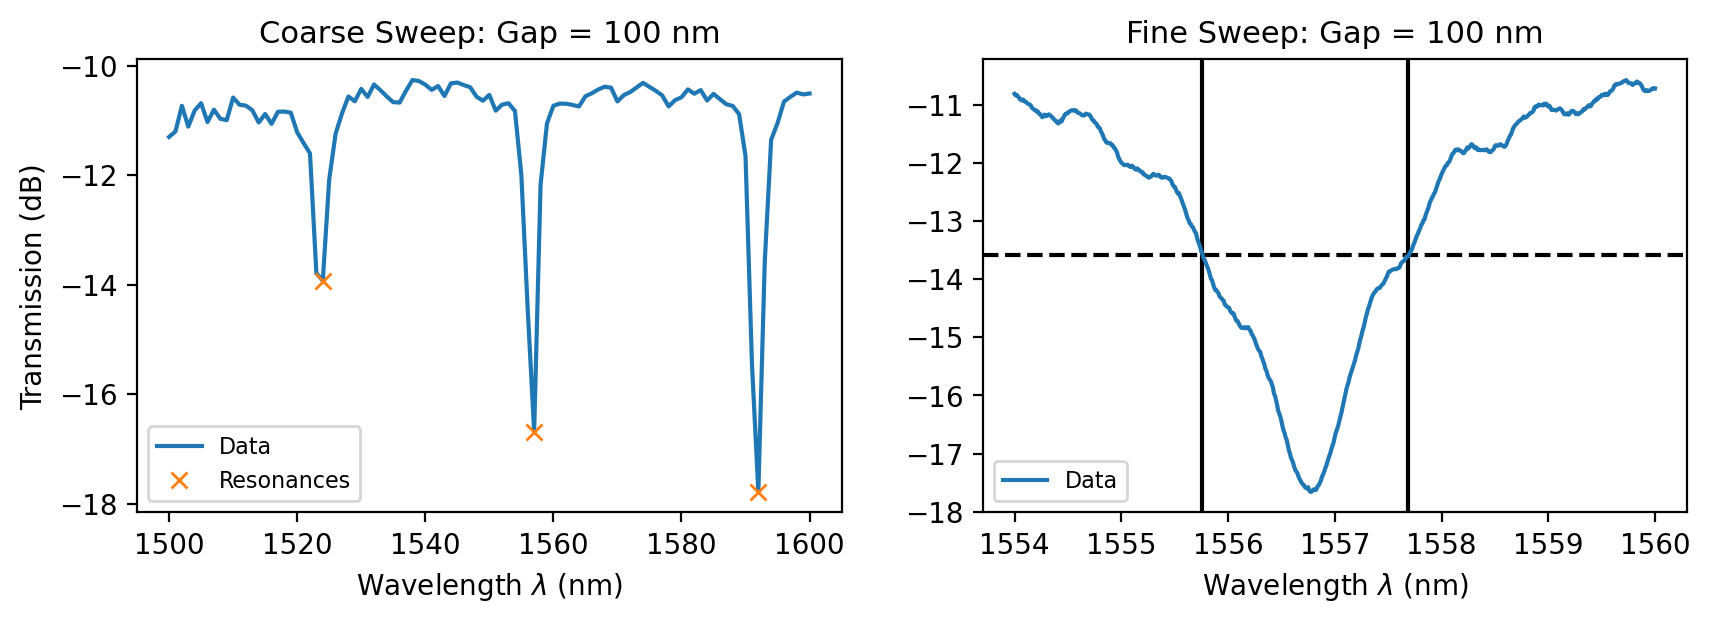

In [373]:
run_analysis(100)

{'resonances': [array([1505., 1537., 1571.]),
  array([-12.2196 , -13.64215, -12.4142 ])],
 'avg_FSR': 33.0,
 'baseline_fine': -10.86693,
 'extinction': 7.554849999999998,
 'FWHM': 0.3499999999996817,
 'λ_near_1550': 1537.1999999999991,
 'Q': 4392.000000003992}

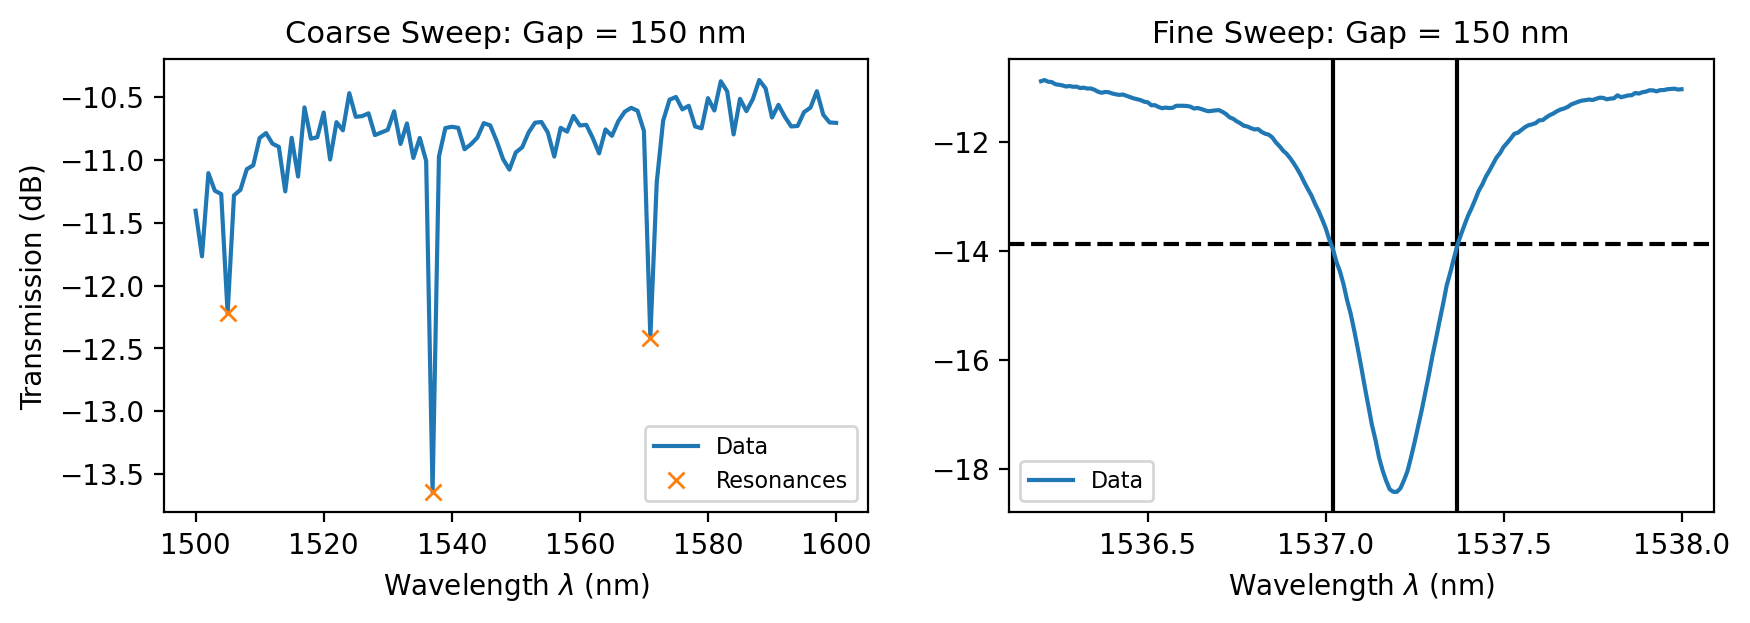

In [374]:
run_analysis(150)

{'resonances': [array([1505.5, 1538. , 1572.5]),
  array([-20.66398, -18.80892, -19.8854 ])],
 'avg_FSR': 33.5,
 'baseline_fine': -15.02976,
 'extinction': 24.68247,
 'FWHM': 0.26999999999975444,
 'λ_near_1550': 1538.139999999999,
 'Q': 5696.8148148199925}

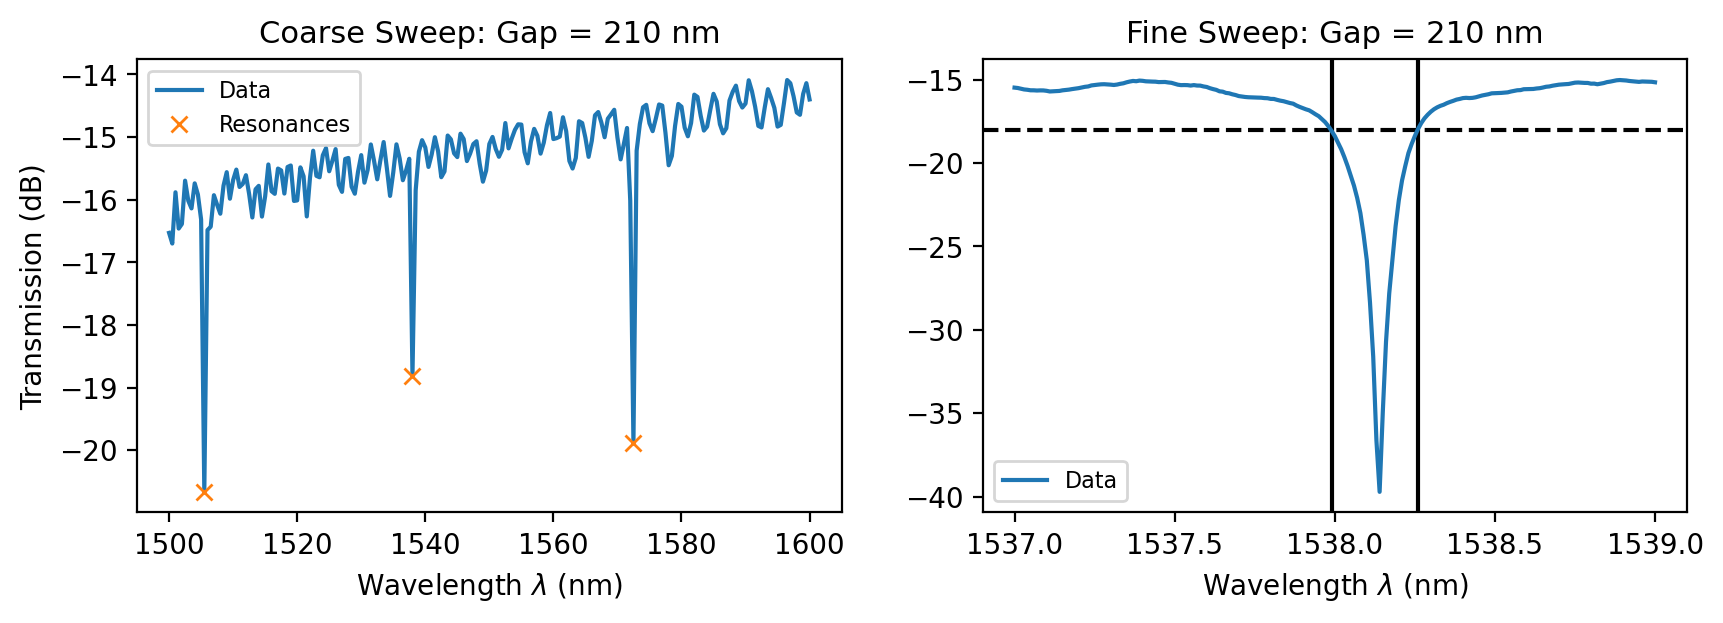

In [375]:
run_analysis(210)

In [474]:
def plot_fine_sweeps():
    """
    Get the fine sweep data, normalize, and plot on the same axes for all gaps.
    """
    
    gaps = [100, 150, 210]
    
    fig, ax = plt.subplots(figsize = (5, 3.5), dpi = 200)
    
    for gap in gaps:
        data = f"Data/0_NoDrop/gap{gap}_really_fine"
        freqs, transmission = data_from_file(data)
        
        analysis = run_analysis(gap, plotting = False)
        fr = analysis["λ_near_1550"]
        baseline = analysis["baseline_fine"]
        
        ax.plot(freqs - fr, transmission - baseline, label = f"Gap = {gap} nm")
        
        
    ax.legend(fontsize=9)
    ax.set_xlabel("Wavelength Detuning $\Delta\lambda = \lambda - \lambda_r$ (nm)")
    ax.set_ylabel("Normalized Transmission (dB)")

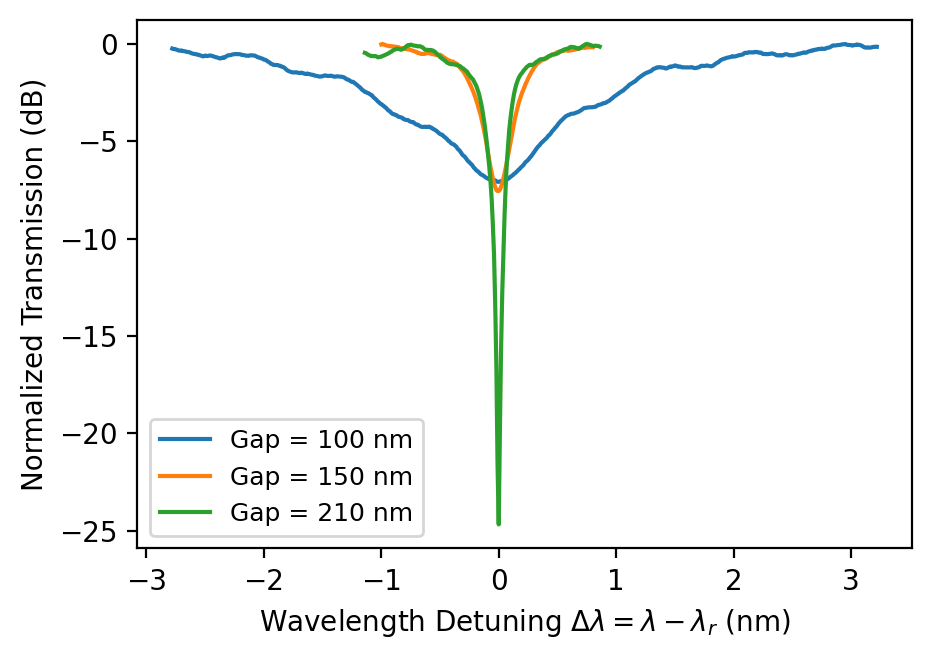

In [475]:
plot_fine_sweeps()

## 1. Add Drop Port Measurements

In [422]:
def add_drop_transmission(plotting = True):
    """
    Plot transmission from the thru and drop ports for the second test structure (gap = 150nm)
    """

    data_drop = "Data/1_AddDrop/addDrop_gap150_drop"
    data_thru = "Data/1_AddDrop/addDrop_gap150_thru"

    fd, Td = data_from_file(data_drop); ft, Tt = data_from_file(data_thru)    
    
    peak_idxs, _ = find_peaks(-Tt, prominence=1)
    peak_freq, peak_T = ft[peak_idxs], Tt[peak_idxs]
    
    if plotting:
        fig, ax = plt.subplots(figsize = (6, 3.5), dpi = 200)
        ax.plot(ft, Tt, label = "Thru Port Data")
        ax.plot(fd, Td, label = "Drop Port Data", zorder=-1)

        ax.axvline(peak_freq[0], c='k', linewidth=1, zorder=-2)
        ax.axvline(peak_freq[1], c='k', linewidth=1, zorder=-2)
        ax.axvline(peak_freq[2], c='k', linewidth=1, zorder=-2, label = "Resonances")
        
        ax.legend(fontsize = 7)
        ax.set_title(f"Coarse Sweep: Gap = 150 nm", fontsize = 11)
        ax.set_ylabel("Transmission (dB)")
        ax.set_xlabel(r"Wavelength $\lambda$ (nm)")

    
    # Calculate resonances and average separation (FSR)
    results = {}
    results["resonances"] = peak_freq, peak_T
    results["avg_FSR"] = (peak_freq[-1] - peak_freq[0]) / (len(peaks) - 1)
    
    return results


{'resonances': (array([1505., 1538., 1572.]),
  array([-13.41921, -19.5022 , -21.32183])),
 'avg_FSR': 33.5}

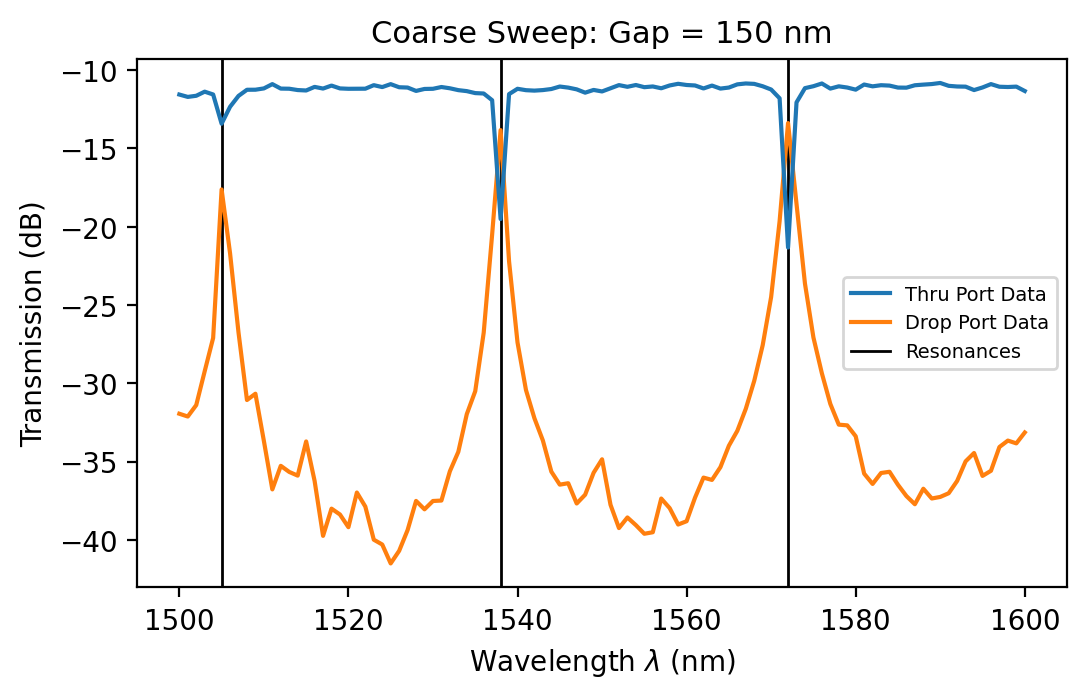

In [423]:
add_drop_transmission()

## 2. Voltage

In [464]:
def add_drop_voltage_sweeps():
    
    data_0V = ["Data/1_AddDrop/addDrop_gap150_thru", "Data/1_AddDrop/addDrop_gap150_thru_fine"]
    data_3V = ["Data/2_AddDropVoltage/addDrop_gap150_thru_3V", "Data/2_AddDropVoltage/addDrop_gap150_thru_3V_fine"]
    labels = ["0V", "3V"]
    
    results = {}
    fig, ax = plt.subplots(1, 2, figsize = (10, 3.5), dpi = 200)
    
    for i, filenames in enumerate([data_0V, data_3V]):
        
        data_coarse = filenames[0]
        freq_coarse, T_coarse = data_from_file(data_coarse)
        
        """ 2. Find Peaks in the Coarse Dataset """
        peak_idxs, _ = find_peaks(-T_coarse, prominence=1)
        peak_freq, peak_T = freq_coarse[peak_idxs], T_coarse[peak_idxs]

        # Calculate resonances and average separation (FSR)
        results[f"resonances_{labels[i]}"] = [peak_freq, peak_T]
        results[f"avg_FSR_{labels[i]}"] = (peak_freq[-1] - peak_freq[0]) / (len(peaks) - 1)
        
        
        
        ax[0].plot(freq_coarse, T_coarse, label = f"Voltage: {labels[i]}")
        ax[0].legend(fontsize = 9)
        ax[0].set_title(f"Coarse Sweep: Gap = 150 nm", fontsize = 11)
        ax[0].set_ylabel("Transmission (dB)")
        ax[0].set_xlabel(r"Wavelength $\lambda$ (nm)")
        
        
        data_fine = filenames[1]
        freq_fine, T_fine = data_from_file(data_fine)
        ax[1].plot(freq_fine, T_fine, label = f"Voltage: {labels[i]}")
        ax[1].legend(fontsize = 9)
        ax[1].set_title(f"Fine Sweep: Gap = 150 nm", fontsize = 11)
        ax[1].set_xlabel(r"Wavelength $\lambda$ (nm)")
        plt.locator_params(axis='x', nbins=4)
        
        results[f"λ0_{labels[i]}"] = freq_fine[np.argmin(T_fine)]
    
    return results

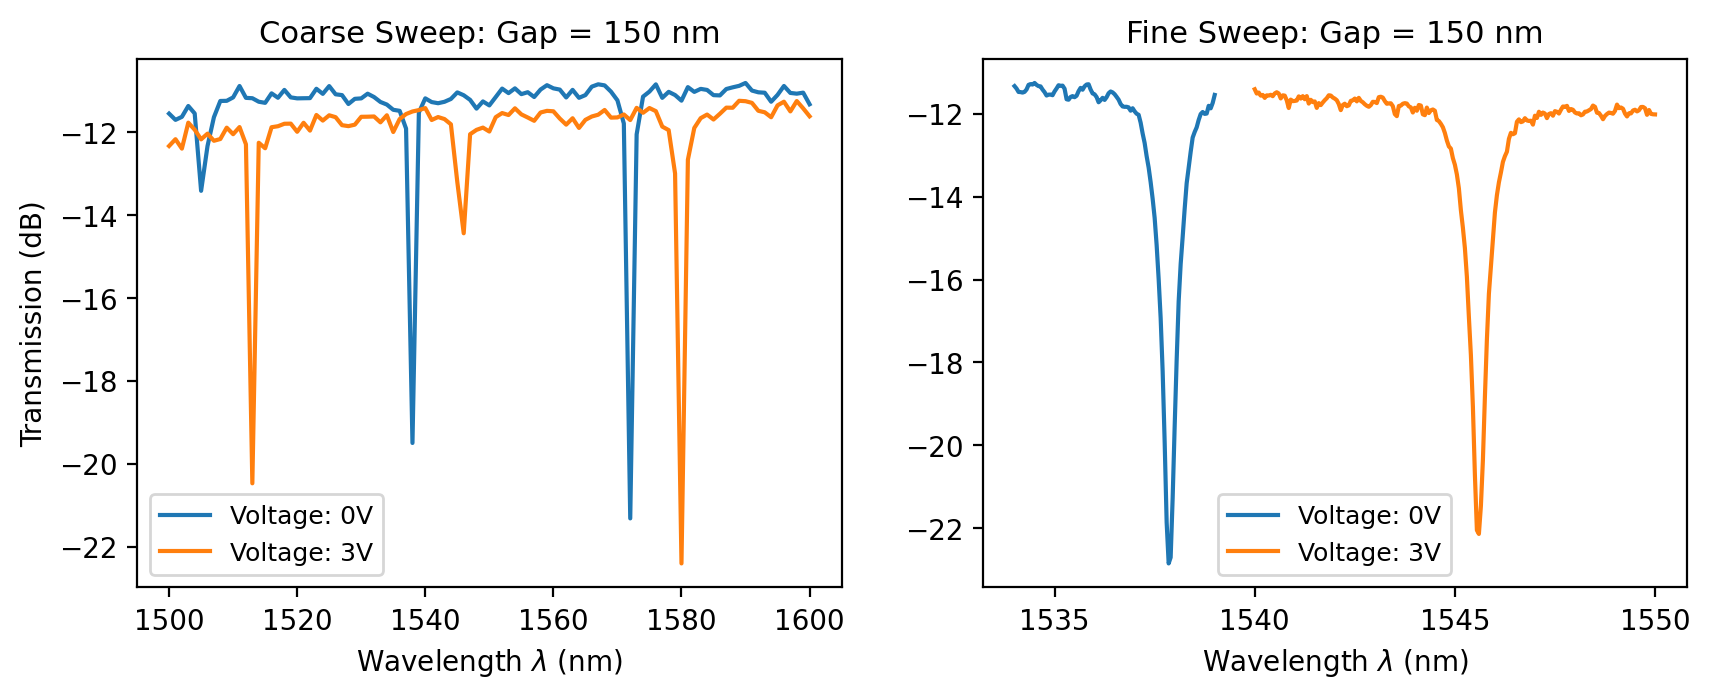

In [466]:
results = add_drop_voltage_sweeps()

In [468]:
results["λ0_3V"] - results["λ0_0V"]

7.749999999998408

In [477]:
results["avg_FSR_0V"] / 4

8.375

Detunes about 1/4 of an FSR!